In [1]:
from fish_helpers import *
base_path = '/home/zach/PythonRepos/PyScripts/MERCI/'
Macrophage = pd.read_csv(os.path.join(base_path,'Macrophage_scRNAseq_Combined.csv'),index_col=0)
Monocytes = pd.read_csv(os.path.join(base_path,'Monocyte_scRNAseq_Combined.csv'),index_col=0)
norm_merged_Matrix_df = pickle.load(open(os.path.join(base_path,'MERCI_Matrix_Expanded_Normalized.pkl'),'rb'))

In [3]:
biomart_download_fname = '/bigstore/binfo/mouse/mouse_ensemble.txt'
transcript_df = pd.read_csv(open(biomart_download_fname, 'r'))
transcript_df.head()

,Gene stable ID,Transcript stable ID,Protein stable ID,Gene description,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Transcript length (including UTRs and CDS),Gene name,Gene % GC content,Gene type,Transcript type,NCBI gene ID
0,ENSMUSG00000064372,ENSMUST00000082423,NaN,mitochondrially encoded tRNA proline [Source:M...,MT,15356,15422,67,mt-Tp,44.78,Mt_tRNA,Mt_tRNA,NaN
1,ENSMUSG00000064371,ENSMUST00000082422,NaN,mitochondrially encoded tRNA threonine [Source...,MT,15289,15355,67,mt-Tt,34.33,Mt_tRNA,Mt_tRNA,NaN
2,ENSMUSG00000064370,ENSMUST00000082421,ENSMUSP00000081003,mitochondrially encoded cytochrome b [Source:M...,MT,14145,15288,1144,mt-Cytb,39.07,protein_coding,protein_coding,17711.0
3,ENSMUSG00000064369,ENSMUST00000082420,NaN,mitochondrially encoded tRNA glutamic acid [So...,MT,14071,14139,69,mt-Te,34.78,Mt_tRNA,Mt_tRNA,NaN
4,ENSMUSG00000064368,ENSMUST00000082419,ENSMUSP00000081002,mitochondrially encoded NADH dehydrogenase 6 [...,MT,13552,14070,519,mt-Nd6,34.10,protein_coding,protein_coding,17722.0


In [127]:
million_reads = np.sum(Monocytes)/10**6
Monoctytes_temp = Monocytes.loc[norm_merged_Matrix_df.index]
Monoctytes_temp.head()

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,Monocyte
0610009B22Rik,58.0
0610010K14Rik,130.0
0610012G03Rik,238.0
0610037L13Rik,62.0
0610040J01Rik,33.0


In [145]:
length = []
for idx in tqdm(Monoctytes_temp.index):
    temp = transcript_df[transcript_df['Gene name']==idx]
    try:
        temp = temp[temp['Transcript type']=='protein_coding'].sort_values(by='Transcript length (including UTRs and CDS)',ascending=False)
        length.append(temp['Transcript length (including UTRs and CDS)'].iloc[0])
    except:
        temp = transcript_df[transcript_df['Gene name']==idx]
        length.append(temp['Transcript length (including UTRs and CDS)'].iloc[0])
            

In [146]:
Monoctytes_temp['length'] = length

In [152]:
million_reads = (np.sum(Monocytes)/10**6)[0]
Monoctytes_temp['FPKM'] = Monoctytes_temp['Monocyte']/Monoctytes_temp['length']/million_reads

In [153]:
Monoctytes_temp.head()

,Monocyte,length,FPKM
0610009B22Rik,58.0,892,0.021273
0610010K14Rik,130.0,880,0.048332
0610012G03Rik,238.0,1445,0.053887
0610037L13Rik,62.0,2997,0.006768
0610040J01Rik,33.0,2008,0.005377


In [156]:
norm_merged_Matrix_df['Monocyte'] = Monoctytes_temp['FPKM'].loc[norm_merged_Matrix_df.index]

In [166]:
import math
bad_idx = []
for row in tqdm(norm_merged_Matrix_df.iterrows()):
    if math.isnan(row[1]['Monocyte']):
        bad_idx.append(row[0])

In [169]:
norm_merged_Matrix_df = norm_merged_Matrix_df.drop(index=bad_idx)

In [4]:
from tqdm import tqdm_notebook as tqdm
genes = []
length = []
bad = []
for idx in tqdm(Macrophage.index):
    try:
        temp_df = transcript_df[transcript_df['Gene stable ID']==idx]
        genes.append(temp_df['Gene name'].iloc[0])
        length.append(temp_df['Transcript length (including UTRs and CDS)'].iloc[0])
    except:
        bad.append(idx)
        genes.append(idx)
        length.append(np.nan)

In [11]:
Macrophage['Ensemble'] = Macrophage.index
Macrophage['length'] = length
Macrophage.index = genes
temp = Macrophage.drop(columns=['Ensemble','length'])
temp_merged = pd.DataFrame(data=np.sum(temp,axis=1),index=temp.index,columns=['Macrophage'])#/np.array(Macrophage['length'])
temp_merged['length'] = Macrophage['length']
million_reads = np.sum(temp_merged['Macrophage'])/(10**6)
temp_merged['FPKM'] = (temp_merged['Macrophage']/Macrophage['length'])/million_reads

In [48]:
temp_merged_filtered = temp_merged.loc[norm_merged_Matrix_df.index]

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [80]:
import math
bad_idx = []
for row in tqdm(temp_merged_filtered.iterrows()):
    if math.isnan(row[1]['FPKM']):
        bad_idx.append(row[0])

In [83]:
norm_merged_Matrix_df = norm_merged_Matrix_df.drop(index=bad_idx)

In [102]:
temp.index[pd.Index(temp.index).duplicated()]


Index(['Ccl19', 'Ccl21a'], dtype='object')

In [112]:
temp['iloc'] = range(0,len(temp))
temp['gene'] =temp.index
temp.index=temp['iloc']
temp.head()

,FPKM,iloc,gene
iloc,,,
0,0.062219,0,0610009B22Rik
1,0.041384,1,0610010K14Rik
2,0.284596,2,0610012G03Rik
3,0.007684,3,0610037L13Rik
4,0.000182,4,0610040J01Rik


In [120]:
temp = temp.drop(index=[1433,1437])
temp.index=temp['gene']
temp = pd.DataFrame(temp['FPKM'])
temp.head()

,FPKM
gene,
0610009B22Rik,0.062219
0610010K14Rik,0.041384
0610012G03Rik,0.284596
0610037L13Rik,0.007684
0610040J01Rik,0.000182


In [121]:
norm_merged_Matrix_df['Macrophage'] = temp.loc[norm_merged_Matrix_df.index]

In [164]:
temp = norm_merged_Matrix_df['Macrophage'].copy()
temp = np.subtract(temp,np.percentile(temp,0.1,axis=0))
temp = np.divide(temp,np.percentile(temp,99.9,axis=0))
norm_merged_Matrix_df['Macrophage'] = temp
norm_merged_Matrix_df.head()

,T cell,NK cell,Neutrophil,Monocyte,Mast cell,Macrophage,Eosinophils,Dendritic cell,B cell,Limbus,Endothelium,Epithelium,Stroma
0610009B22Rik,0.008044,0.007563,0.073075,0.021273,0.070563,0.011250,0.561735,0.012202,0.006180,0.004341,0.021494,0.007760,0.011443
0610010K14Rik,0.020828,0.012553,0.250279,0.048332,0.196324,0.007483,0.000000,0.012790,0.001163,0.004144,0.018397,0.010133,0.013077
0610012G03Rik,0.040022,0.022226,0.359282,0.053887,0.334367,0.051460,0.340185,0.077825,0.008353,0.008541,0.009633,0.002662,0.005999
0610037L13Rik,0.013024,0.011431,0.485948,0.006768,0.321101,0.001389,0.486166,0.023598,0.008144,0.005302,0.005332,0.004150,0.006425
0610040J01Rik,0.000316,0.000128,0.042130,0.005377,0.028640,0.000033,0.351884,0.001872,0.000097,0.000008,0.000094,0.000101,0.000098


In [170]:
temp = norm_merged_Matrix_df['Monocyte'].copy()
temp = np.subtract(temp,np.percentile(temp,0.1,axis=0))
temp = np.divide(temp,np.percentile(temp,99.9,axis=0))
norm_merged_Matrix_df['Monocyte'] = temp
norm_merged_Matrix_df.head()

,T cell,NK cell,Neutrophil,Monocyte,Mast cell,Macrophage,Eosinophils,Dendritic cell,B cell,Limbus,Endothelium,Epithelium,Stroma
0610009B22Rik,0.008044,0.007563,0.073075,0.006162,0.070563,0.011250,0.561735,0.012202,0.006180,0.004341,0.021494,0.007760,0.011443
0610010K14Rik,0.020828,0.012553,0.250279,0.014000,0.196324,0.007483,0.000000,0.012790,0.001163,0.004144,0.018397,0.010133,0.013077
0610012G03Rik,0.040022,0.022226,0.359282,0.015610,0.334367,0.051460,0.340185,0.077825,0.008353,0.008541,0.009633,0.002662,0.005999
0610037L13Rik,0.013024,0.011431,0.485948,0.001961,0.321101,0.001389,0.486166,0.023598,0.008144,0.005302,0.005332,0.004150,0.006425
0610040J01Rik,0.000316,0.000128,0.042130,0.001558,0.028640,0.000033,0.351884,0.001872,0.000097,0.000008,0.000094,0.000101,0.000098


In [175]:
temp = norm_merged_Matrix_df['Eosinophils'].copy()
temp = np.subtract(temp,np.percentile(temp,0.1,axis=0))
temp = np.divide(temp,np.percentile(temp,99.9,axis=0))
norm_merged_Matrix_df['Eosinophils'] = temp
norm_merged_Matrix_df.head()

,T cell,NK cell,Neutrophil,Monocyte,Mast cell,Macrophage,Eosinophils,Dendritic cell,B cell,Limbus,Endothelium,Epithelium,Stroma
0610009B22Rik,0.008044,0.007563,0.073075,0.006162,0.070563,0.011250,0.561355,0.012202,0.006180,0.004341,0.021494,0.007760,0.011443
0610010K14Rik,0.020828,0.012553,0.250279,0.014000,0.196324,0.007483,0.000000,0.012790,0.001163,0.004144,0.018397,0.010133,0.013077
0610012G03Rik,0.040022,0.022226,0.359282,0.015610,0.334367,0.051460,0.339955,0.077825,0.008353,0.008541,0.009633,0.002662,0.005999
0610037L13Rik,0.013024,0.011431,0.485948,0.001961,0.321101,0.001389,0.485837,0.023598,0.008144,0.005302,0.005332,0.004150,0.006425
0610040J01Rik,0.000316,0.000128,0.042130,0.001558,0.028640,0.000033,0.351646,0.001872,0.000097,0.000008,0.000094,0.000101,0.000098


In [176]:
pickle.dump(norm_merged_Matrix_df,open(os.path.join(base_path,'MERCI_Matrix_Expanded_Normalized.pkl'),'wb'))

In [177]:
norm_merged_Matrix_df = pickle.load(open(os.path.join(base_path,'MERCI_Matrix_Expanded_Normalized.pkl'),'rb'))
norm_merged_Matrix_df.head()

,T cell,NK cell,Neutrophil,Monocyte,Mast cell,Macrophage,Eosinophils,Dendritic cell,B cell,Limbus,Endothelium,Epithelium,Stroma
0610009B22Rik,0.008044,0.007563,0.073075,0.006162,0.070563,0.011250,0.561355,0.012202,0.006180,0.004341,0.021494,0.007760,0.011443
0610010K14Rik,0.020828,0.012553,0.250279,0.014000,0.196324,0.007483,0.000000,0.012790,0.001163,0.004144,0.018397,0.010133,0.013077
0610012G03Rik,0.040022,0.022226,0.359282,0.015610,0.334367,0.051460,0.339955,0.077825,0.008353,0.008541,0.009633,0.002662,0.005999
0610037L13Rik,0.013024,0.011431,0.485948,0.001961,0.321101,0.001389,0.485837,0.023598,0.008144,0.005302,0.005332,0.004150,0.006425
0610040J01Rik,0.000316,0.000128,0.042130,0.001558,0.028640,0.000033,0.351646,0.001872,0.000097,0.000008,0.000094,0.000101,0.000098


In [181]:
norm_merged_Matrix_df.max()

T cell             1.549205
NK cell            2.070633
Neutrophil         1.394005
Monocyte           3.969802
Mast cell          1.599042
Macrophage        12.180159
Eosinophils        1.126998
Dendritic cell     1.574997
B cell             2.823750
Limbus             4.174256
Endothelium        2.673428
Epithelium         6.284690
Stroma             4.306837
dtype: float64

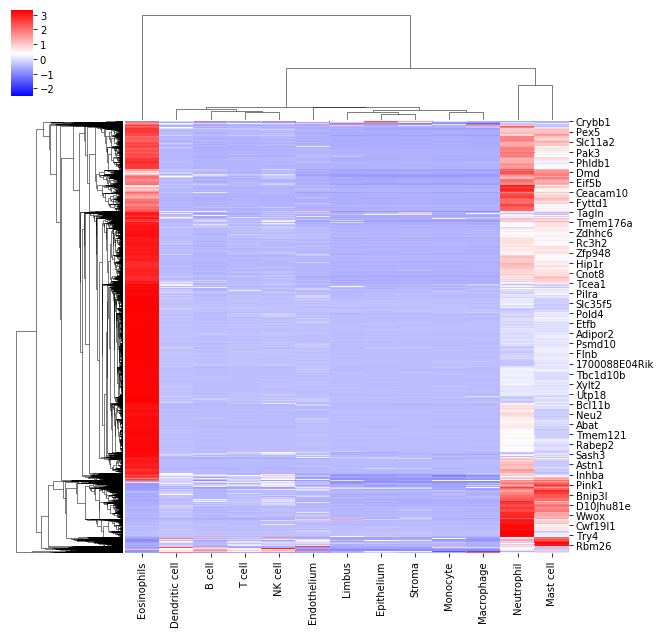

In [205]:
import seaborn as sns
sns.clustermap(norm_merged_Matrix_df,z_score=0,cmap='bwr')
plt.show()

In [183]:
import scipy.stats as ss
rank_Matrix = norm_merged_Matrix_df.copy()
for cell in rank_Matrix.columns:
    rank_Matrix[cell] = ss.rankdata(rank_Matrix[cell])
rank_Matrix.head()

,T cell,NK cell,Neutrophil,Monocyte,Mast cell,Macrophage,Eosinophils,Dendritic cell,B cell,Limbus,Endothelium,Epithelium,Stroma
0610009B22Rik,5979.0,5888.0,3901.0,8423.0,4209.0,9503.0,7850.0,5977.0,6870.0,7501.0,8447.0,8593.0,9128.0
0610010K14Rik,8082.0,6834.0,8544.0,9460.0,8399.0,9150.0,838.0,6116.5,4524.0,7414.0,8118.0,9039.0,9312.0
0610012G03Rik,9209.0,7887.0,9579.0,9566.0,9867.0,10229.0,4662.0,9634.0,7354.0,8766.0,6424.0,6147.0,7881.0
0610037L13Rik,7073.0,6666.0,10186.0,6361.0,9795.0,6908.0,6622.0,7713.0,7316.0,7896.0,5009.0,7247.0,8050.0
0610040J01Rik,1363.0,486.0,1646.0,5910.0,1968.0,2748.0,4808.0,1482.0,939.0,534.0,2087.0,2423.0,1128.0


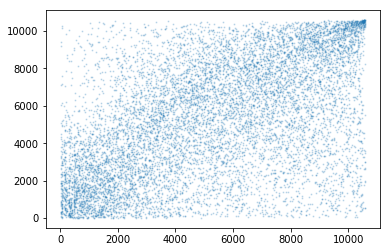

In [188]:
plt.scatter(rank_Matrix['Limbus'],rank_Matrix['B cell'],s=1,alpha=0.2)
plt.show()

SpearmanrResult(correlation=0.5921959423491894, pvalue=0.0)


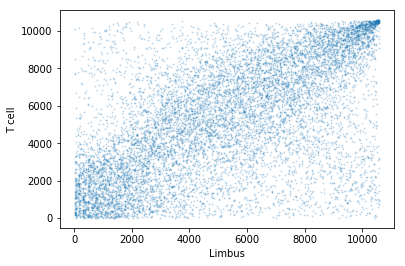

SpearmanrResult(correlation=0.5497224909181853, pvalue=0.0)


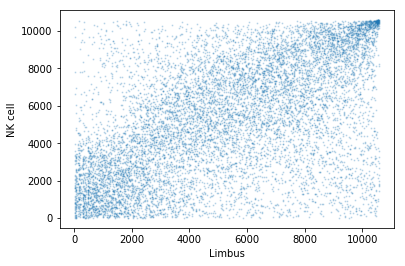

SpearmanrResult(correlation=0.22271304658065924, pvalue=5.102333850406365e-119)


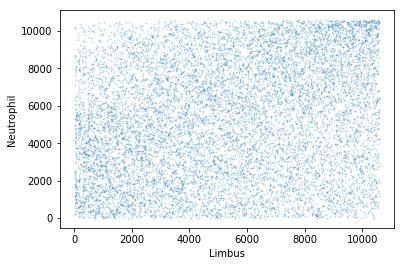

SpearmanrResult(correlation=0.5806946159581768, pvalue=0.0)


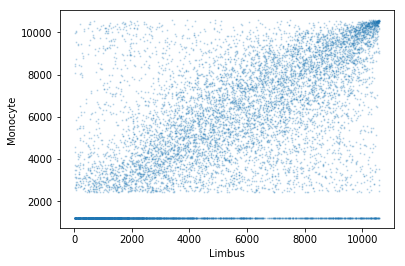

SpearmanrResult(correlation=0.5113255784359049, pvalue=0.0)


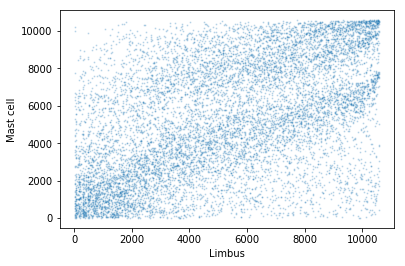

SpearmanrResult(correlation=0.6118632795966457, pvalue=0.0)


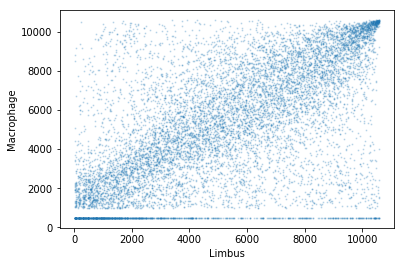

SpearmanrResult(correlation=0.35118352783197343, pvalue=1.1529719003569216e-304)


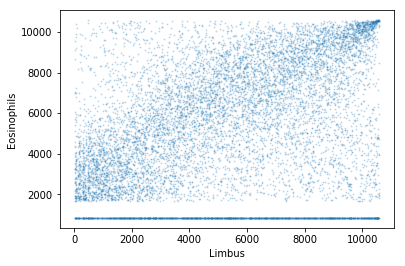

SpearmanrResult(correlation=0.586157500262055, pvalue=0.0)


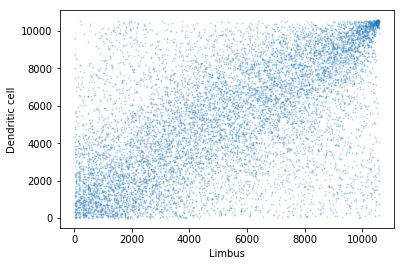

SpearmanrResult(correlation=0.516996247161679, pvalue=0.0)


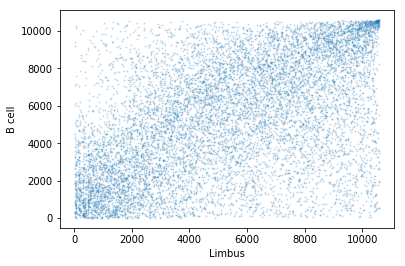

SpearmanrResult(correlation=1.0, pvalue=0.0)


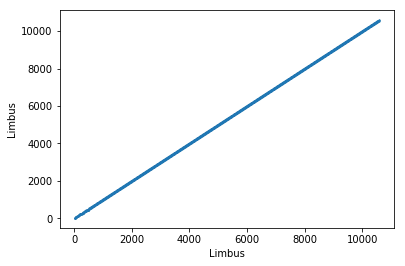

SpearmanrResult(correlation=0.695171408034057, pvalue=0.0)


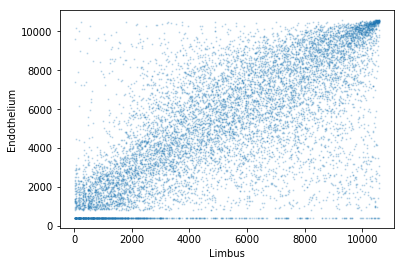

SpearmanrResult(correlation=0.8141080545462521, pvalue=0.0)


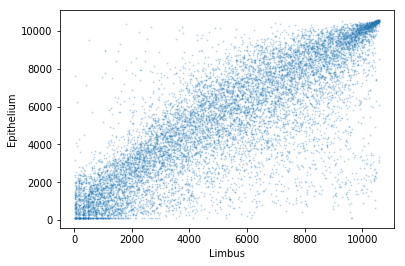

SpearmanrResult(correlation=0.8097294960693556, pvalue=0.0)


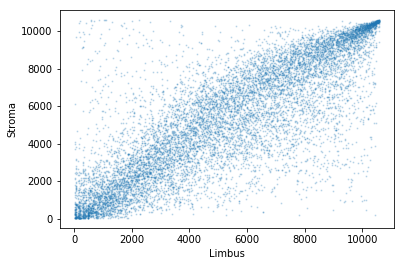

In [190]:
X = rank_Matrix['Limbus']
for column in rank_Matrix.columns:
    Y = rank_Matrix[column]
    print(spearmanr(X,Y))
    plt.scatter(X,Y,s=1,alpha=0.2)
    plt.xlabel('Limbus')
    plt.ylabel(column)
    plt.show()

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


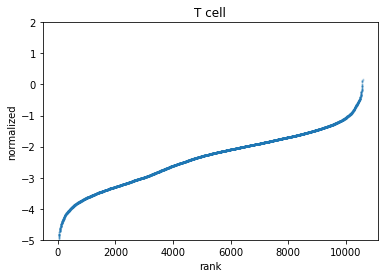

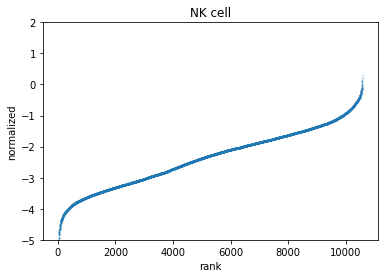

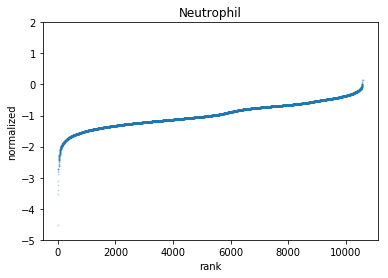

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


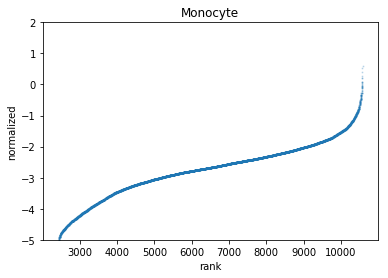

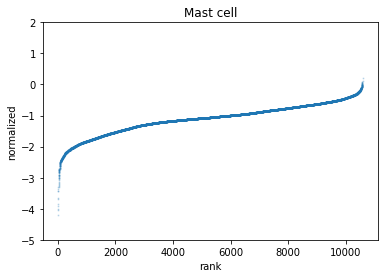

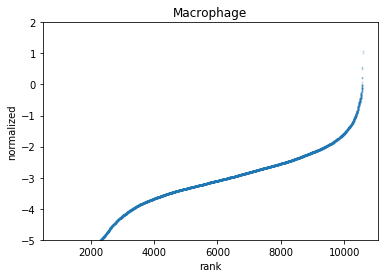

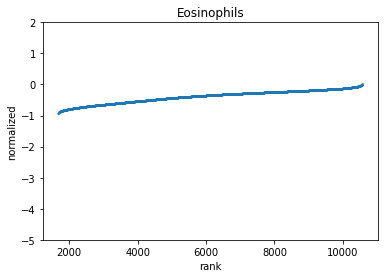

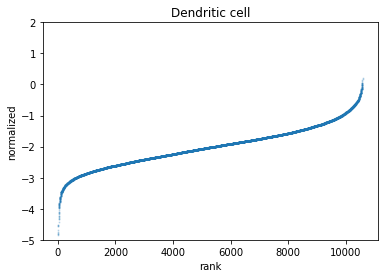

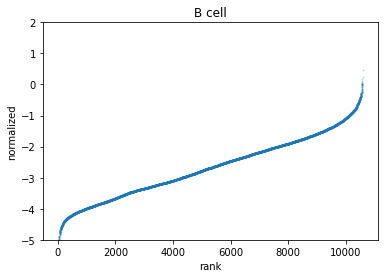

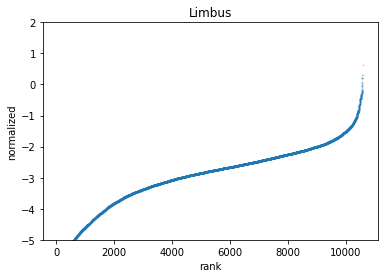

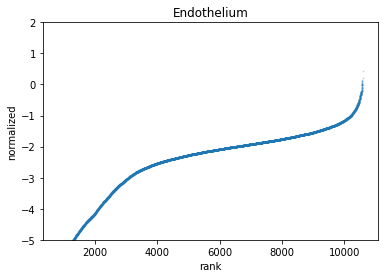

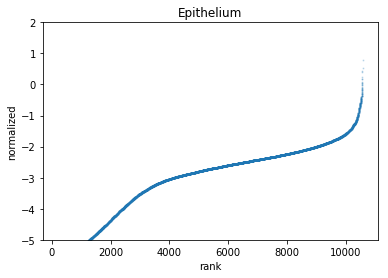

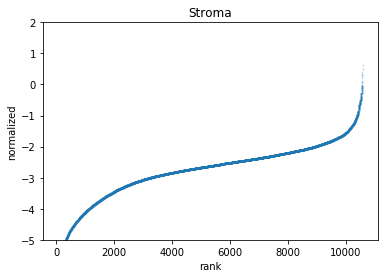

In [197]:
for column in rank_Matrix.columns:
    plt.scatter(rank_Matrix[column],np.log10(norm_merged_Matrix_df[column]),s=1,alpha=0.2)
    plt.xlabel('rank')
    plt.ylabel('normalized')
    plt.ylim([-5,2])
    plt.title(column)
    plt.show()

In [211]:
rank_Matrix[column].min()

1.0

In [212]:
rank_Matrix[column].max()

10578.0

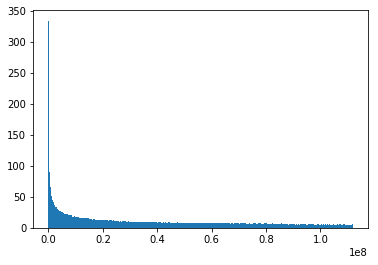

In [217]:
plt.hist((rank_Matrix[column])**2,bins=1000)
plt.show()

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


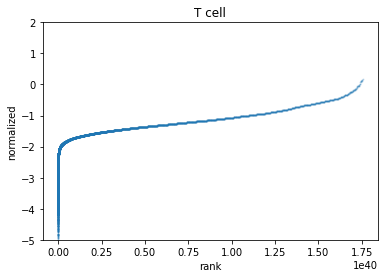

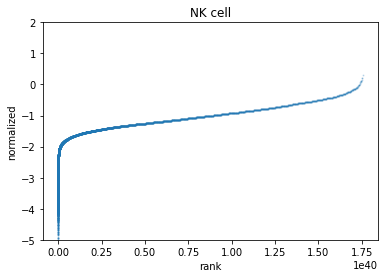

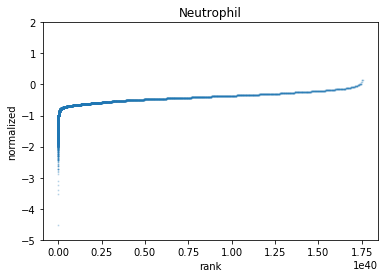

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


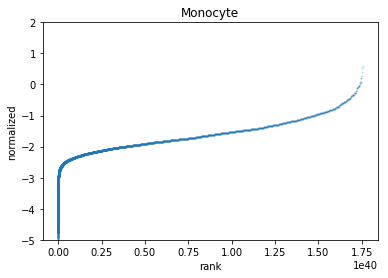

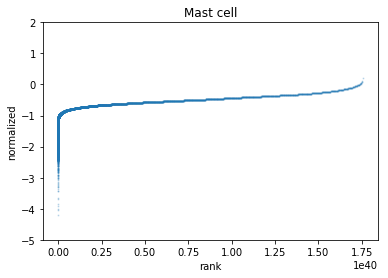

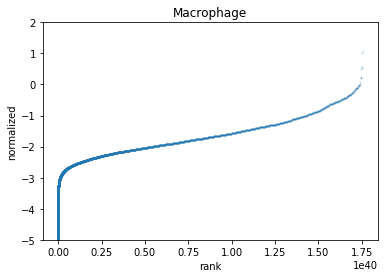

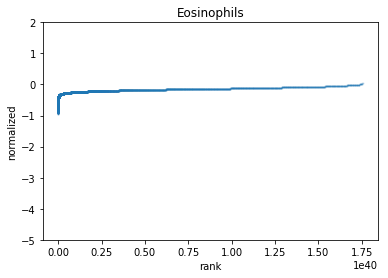

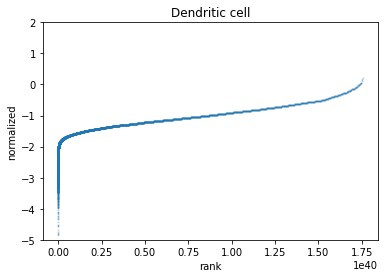

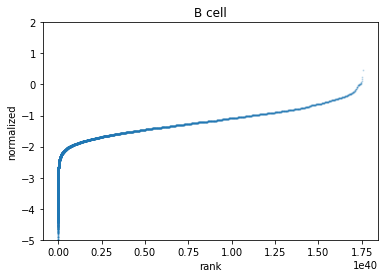

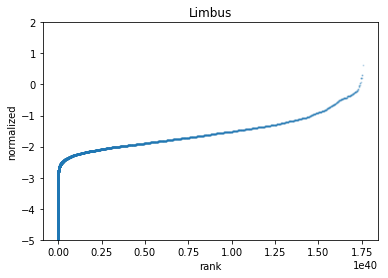

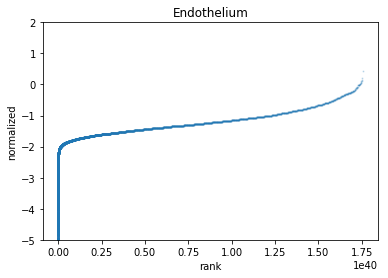

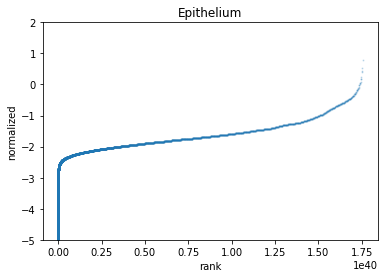

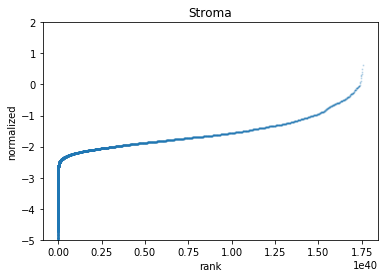

In [218]:
for column in rank_Matrix.columns:
    plt.scatter((rank_Matrix[column])**10,np.log10(norm_merged_Matrix_df[column]),s=1,alpha=0.2)
    plt.xlabel('rank')
    plt.ylabel('normalized')
    plt.ylim([-5,2])
    plt.title(column)
    plt.show()

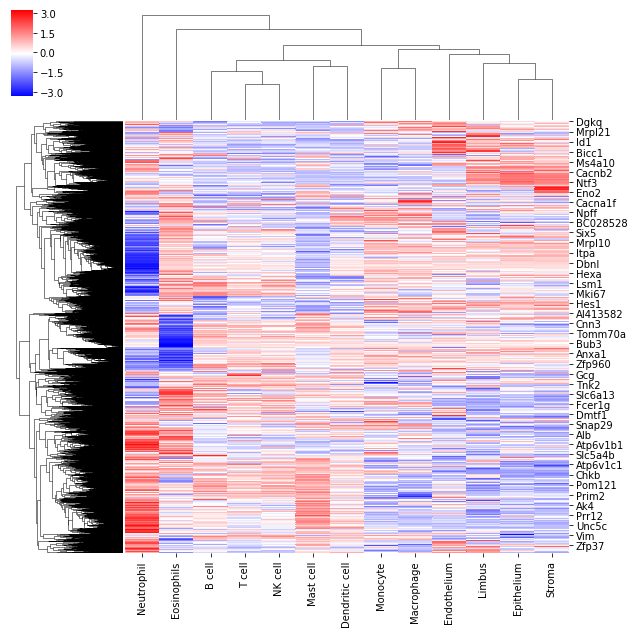

In [192]:
import seaborn as sns
sns.clustermap(rank_Matrix,z_score=0,cmap='bwr')
plt.show()

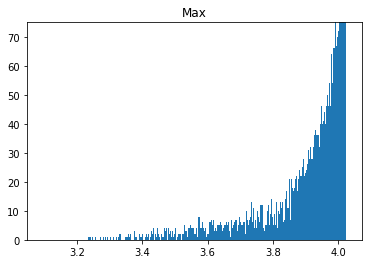

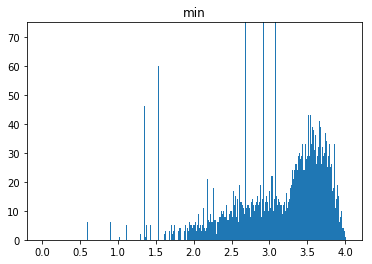

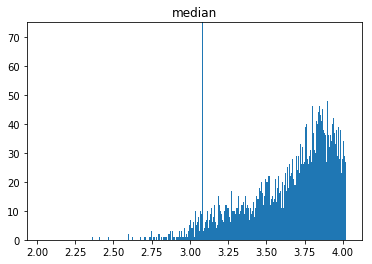

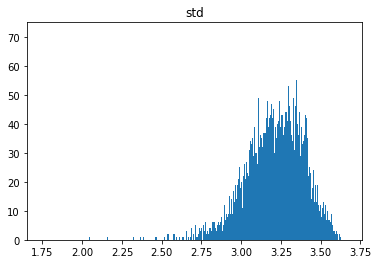

In [222]:
temp_df = rank_Matrix.copy()
plt.hist(np.log10(np.max(temp_df,axis=1)),bins=1000)
plt.ylim([0,75])
plt.title('Max')
plt.show()
plt.hist(np.log10(np.min(temp_df,axis=1)),bins=1000)
plt.ylim([0,75])
plt.title('min')
plt.show()
plt.hist(np.log10(np.median(temp_df,axis=1)),bins=1000)
plt.ylim([0,75])
plt.title('median')
plt.show()
plt.hist(np.log10(np.std(temp_df,axis=1)),bins=1000)
plt.ylim([0,75])
plt.title('std')
plt.show()


7933


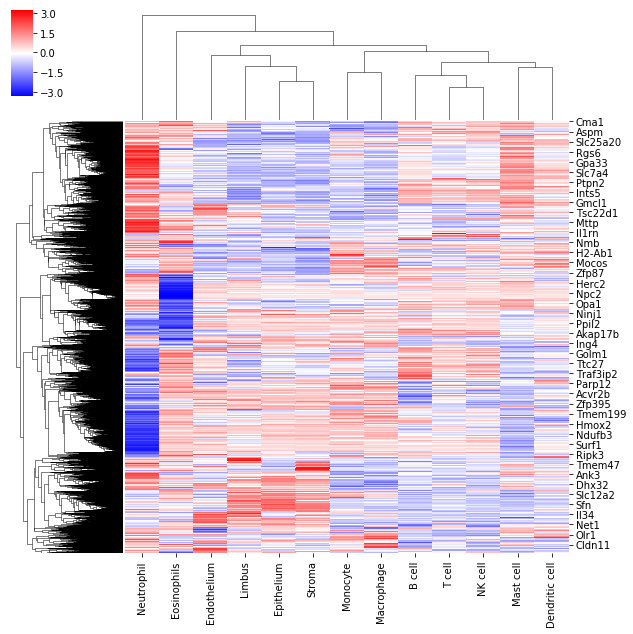

In [229]:
import seaborn as sns
temp_df = rank_Matrix.copy()
T =25
min_t = np.percentile(np.min(temp_df,axis=1),T)
max_t = np.percentile(np.max(temp_df,axis=1),100-T)
std_min_t = np.percentile(np.std(temp_df,axis=1),T)
temp_df = temp_df[(np.max(temp_df,axis=1)>min_t)&
                  (np.min(temp_df,axis=1)<max_t)&
                  (np.std(temp_df,axis=1)>std_min_t)]
print(len(temp_df))
sns.clustermap(temp_df,z_score=0,cmap='bwr')
plt.show()

In [201]:
import operator
from random import sample
import time
codebook_dict = {}
ne = operator.ne
min_length = 4
max_length = 8
hamming = 2
positive_bits = 3
bits = '01'
for i in range(max_length+1):
    if i<min_length:
        continue
    best_candidates = []
    very_last_time = time.time()
    base_str = str(''.join('1' for i in range(positive_bits)))+str(''.join('0' for i in range(i-positive_bits)))
    print(base_str)
    while time.time()-very_last_time<10:
        candidates = []
        bad_candidates = []
        last_time = time.time()
        while time.time()-last_time<0.5:
            candidate = ''.join(sample(base_str,len(base_str)))
            if candidate in candidates:
                continue
            elif candidate in bad_candidates:
                continue
            good = 0
            for can in candidates:
                    if sum(map(ne, can, candidate)) < hamming:
                        good+=1
                        bad_candidates.append(candidate)
                        break
            if good==0:
                candidates.append(candidate)
                last_time = time.time()
        if len(candidates)>len(best_candidates):
            best_candidates = candidates
            very_last_time = time.time()
            
    print(i,' Total Barcodes: ',len(best_candidates))
    codebook_dict[str(i)] = best_candidates

1110
4  Total Barcodes:  4
11100
5  Total Barcodes:  10
111000
6  Total Barcodes:  20
1110000
7  Total Barcodes:  35
11100000
8  Total Barcodes:  56


In [230]:
codebook = np.zeros([len(codebook_dict['6']),len(codebook_dict['6'][1])])
for y,barcode in enumerate(codebook_dict['6']):
    for x,bit in enumerate(str(barcode)):
        codebook[y,x] = int(bit)
codebook_df = pd.DataFrame(data=codebook)

In [239]:
temp_df = rank_Matrix.copy()
T =25
min_t = np.percentile(np.min(temp_df,axis=1),T)
max_t = np.percentile(np.max(temp_df,axis=1),100-T)
std_min_t = np.percentile(np.std(temp_df,axis=1),T)
temp_df = temp_df[(np.max(temp_df,axis=1)>min_t)&
                  (np.min(temp_df,axis=1)<max_t)&
                  (np.std(temp_df,axis=1)>std_min_t)]
Expression_df = temp_df
for i in range(len(codebook_df.index)-len(Expression_df.columns)):
    Expression_df['Blank'+str(i)] = 0
Expression_df.head()

,T cell,NK cell,Neutrophil,Monocyte,Mast cell,Macrophage,Eosinophils,Dendritic cell,B cell,Limbus,Endothelium,Epithelium,Stroma,Blank0,Blank1,Blank2,Blank3,Blank4,Blank5,Blank6
0610009B22Rik,5979.0,5888.0,3901.0,8423.0,4209.0,9503.0,7850.0,5977.0,6870.0,7501.0,8447.0,8593.0,9128.0,0,0,0,0,0,0,0
0610010K14Rik,8082.0,6834.0,8544.0,9460.0,8399.0,9150.0,838.0,6116.5,4524.0,7414.0,8118.0,9039.0,9312.0,0,0,0,0,0,0,0
0610012G03Rik,9209.0,7887.0,9579.0,9566.0,9867.0,10229.0,4662.0,9634.0,7354.0,8766.0,6424.0,6147.0,7881.0,0,0,0,0,0,0,0
0610037L13Rik,7073.0,6666.0,10186.0,6361.0,9795.0,6908.0,6622.0,7713.0,7316.0,7896.0,5009.0,7247.0,8050.0,0,0,0,0,0,0,0
0610040J01Rik,1363.0,486.0,1646.0,5910.0,1968.0,2748.0,4808.0,1482.0,939.0,534.0,2087.0,2423.0,1128.0,0,0,0,0,0,0,0


In [237]:
codebook_df.index = Expression_df.columns
codebook_df

,0,1,2,3,4,5
T cell,0.0,1.0,0.0,0.0,1.0,1.0
NK cell,0.0,1.0,1.0,0.0,0.0,1.0
Neutrophil,1.0,0.0,1.0,0.0,0.0,1.0
Monocyte,1.0,1.0,0.0,0.0,1.0,0.0
Mast cell,0.0,0.0,0.0,1.0,1.0,1.0
Macrophage,1.0,1.0,1.0,0.0,0.0,0.0
Eosinophils,1.0,0.0,0.0,1.0,1.0,0.0
Dendritic cell,1.0,0.0,1.0,0.0,1.0,0.0
B cell,1.0,1.0,0.0,0.0,0.0,1.0
Limbus,1.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
temp = np.zeros()

0 502
1 136
2 327
3 187
4 87
5 345


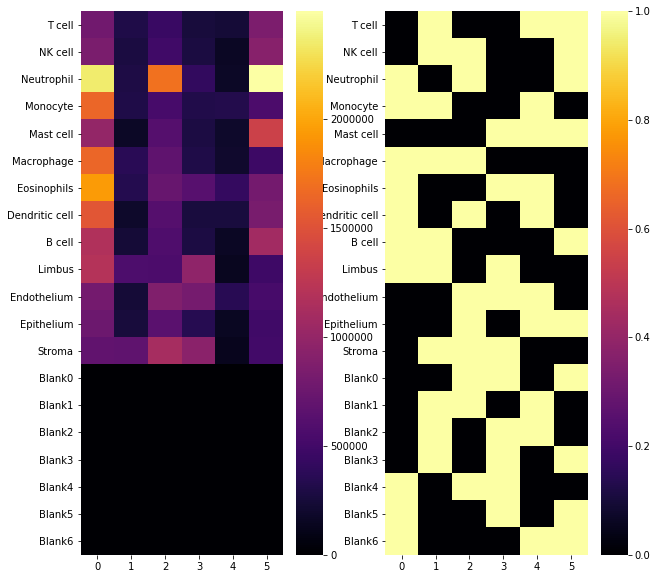

In [258]:
gene_bitmap = {}
Readout_df = pd.DataFrame(index=Expression_df.columns,columns=codebook_df.columns)
for bit in codebook_df.columns:
    pos_cells = []
    neg_cells = []
    for cell in codebook_df[bit].index:
        if codebook_df[bit][cell]==1:
            pos_cells.append(cell)
        else:
            neg_cells.append(cell)
    pos_Immune_DF = Expression_df[pos_cells]
    neg_Immune_DF = Expression_df[neg_cells]
    Zscore = np.max(pos_Immune_DF,axis=1)/np.max(neg_Immune_DF,axis=1)
    pos_genes = Zscore[Zscore>2].index
    print(bit,len(pos_genes))
    gene_bitmap[bit] = pos_genes
    Readout_df[bit] = np.sum(Expression_df.loc[pos_genes],axis=0)
import seaborn as sns
fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
ax1,ax2 = axes
im1 = sns.heatmap(Readout_df,cmap='inferno',ax=ax1)
im2 = sns.heatmap(codebook_df,cmap='inferno',ax=ax2)
plt.show()

In [243]:
pos_genes

Index([], dtype='object')

In [242]:
Expression_df[pos_cells]

,T cell,NK cell,Neutrophil,Mast cell,B cell,Epithelium,Blank0,Blank3,Blank5,Blank6
0610009B22Rik,5979.0,5888.0,3901.0,4209.0,6870.0,8593.0,0,0,0,0
0610010K14Rik,8082.0,6834.0,8544.0,8399.0,4524.0,9039.0,0,0,0,0
0610012G03Rik,9209.0,7887.0,9579.0,9867.0,7354.0,6147.0,0,0,0,0
0610037L13Rik,7073.0,6666.0,10186.0,9795.0,7316.0,7247.0,0,0,0,0
0610040J01Rik,1363.0,486.0,1646.0,1968.0,939.0,2423.0,0,0,0,0
1110004F10Rik,8317.0,8063.0,135.5,6134.0,7473.0,9704.0,0,0,0,0
1110008P14Rik,8173.0,5638.0,9773.0,9846.0,6640.0,8743.0,0,0,0,0
1110012L19Rik,5766.0,5503.0,705.0,4657.0,5788.0,6247.0,0,0,0,0
1110032A03Rik,4049.0,3433.0,2950.0,4433.0,2276.0,6469.0,0,0,0,0
1110038F14Rik,6390.0,7061.0,4458.0,4364.0,6263.0,7555.0,0,0,0,0


In [234]:
pos_cells

[2, 3, 5, 6, 7, 8, 9, 17, 18, 19]